# Initialization

In [65]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import wcs
from astropy.visualization import simple_norm
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
import astropy.units as u

from astroquery.gaia import Gaia
from photutils import (SkyCircularAperture, SkyCircularAnnulus, aperture_photometry)

# Load and prepocessing the fits file

In [3]:
path = './data/beker/Baker/'

In [47]:
hdu = fits.open(f'{path}tests/image01.new')
header = hdu[0].header
data = hdu[0].data
w = wcs.WCS(hdu[0].header)
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 306.247419363  17.1101734206  
CRPIX : 399.158182144  955.325149536  
CD1_1 CD1_2  : 0.000301103373416  -5.53620441845e-07  
CD2_1 CD2_2  : 5.21741078386e-07  0.000301191948637  
NAXIS : 3056  3056

In [25]:
print(np.min(data), np.max(data), np.median(data))
cond = data<0.0
data[cond] = 0

-21368.0 63528.0 64.0


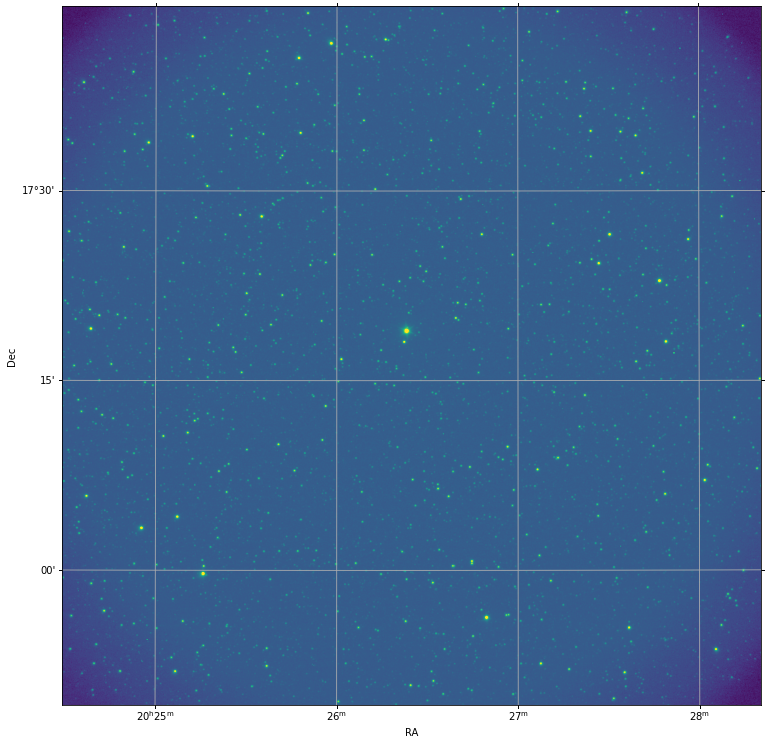

In [44]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(111, projection=w)
norm = simple_norm(data, 'log', min_percent=0, max_percent=99.99)
plt.imshow(data, origin='lower', cmap=plt.cm.viridis, norm=norm)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.grid(True)
fig.tight_layout()

In [55]:
wcs_corners = w.wcs_pix2world(np.array([[0,0], [header['NAXIS1'], header['NAXIS2']]]), 0)
wcs_corners

array([[306.12272648,  16.82249546],
       [307.086347  ,  17.74275895]])

# Getting the Gaia catalog

In [66]:
coord = SkyCoord(ra=wcs_corners[0][0], dec=wcs_corners[0][1], unit=(u.degree, u.degree), frame='icrs')
width = u.Quantity(1.0, u.deg)
height = u.Quantity(1.0, u.deg)
r = Gaia.query_object_async(coordinate=coord, width=width, height=height)
r.pprint()

INFO: Query finished. [astroquery.utils.tap.core]
         dist             solution_id     ... epoch_photometry_url
                                          ...                     
--------------------- ------------------- ... --------------------
0.0014400029910648464 1635721458409799680 ...                     
0.0014791586871047383 1635721458409799680 ...                     
0.0020260665410270426 1635721458409799680 ...                     
  0.00330545995725943 1635721458409799680 ...                     
0.0033841450777893334 1635721458409799680 ...                     
 0.004172367186842469 1635721458409799680 ...                     
 0.005133373353935611 1635721458409799680 ...                     
 0.006221149482619641 1635721458409799680 ...                     
 0.006933287941640287 1635721458409799680 ...                     
  0.00723953947751152 1635721458409799680 ...                     
                  ...                 ... ...                  ...
 0.014539912

In [190]:
c_ra = wcs_corners[0][0] + (wcs_corners[1][0] -  wcs_corners[0][0]) / 2
c_dec = wcs_corners[0][1] + (wcs_corners[1][1] -  wcs_corners[0][1]) / 2
print(c_ra, c_dec)

req = ("SELECT\n"
    "gaia_source.ra, gaia_source.dec,\n"
    "gaia_source.phot_g_mean_mag, gaia_source.phot_bp_mean_mag, gaia_source.phot_rp_mean_mag\n"
    "FROM gaiadr2.gaia_source \n"
    "WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec), "
    f"BOX('ICRS',{c_ra},{c_dec},0.8,0.8))=1"
      "AND phot_g_mean_mag between 10 and 15")
job = Gaia.launch_job(req)
res = job.get_results()
print(res)

306.60453674175847 17.282627208042484
        ra                dec         ... phot_bp_mean_mag phot_rp_mean_mag
       deg                deg         ...       mag              mag       
------------------ ------------------ ... ---------------- ----------------
 306.7016081470453 17.085153596051214 ...        15.490036        14.078336
306.25545278195153 17.292286619038975 ...        12.786334        11.912152
 306.6666135204188  17.24777679864173 ...        13.205481        12.902766
306.63440298746184 17.086750796208523 ...        14.548392        13.241091
 306.7959189397084 17.284706795708292 ...        13.845824        11.961081
 306.2969730734127 17.278085741093314 ...        12.154097        11.396539
306.64514857376406 17.218857072006507 ...       14.5898905        13.780592
306.51661748665043  17.00738808387739 ...        15.290735        14.436755
 306.5825843584886 17.265851606378398 ...        13.205854        12.425399
306.77213163914155 17.247494266599997 ...        1

# Stars identification

In [192]:
position = SkyCoord(ra=res['ra'], dec=res['dec'], frame='icrs')
position

<SkyCoord (ICRS): (ra, dec) in deg
    [(306.70160815, 17.0851536 ), (306.25545278, 17.29228662),
     (306.66661352, 17.2477768 ), ..., (306.21251581, 17.12239469),
     (306.25739778, 17.20745383), (306.21833745, 17.12509449)]>

In [193]:
aperture = SkyCircularAperture(position, r=6. * u.arcsec)
annulus_aperture = SkyCircularAnnulus(position, r_in=10 * u.arcsec, r_out=15 * u.arcsec)
pix_aperture = aperture.to_pixel(wcs=w)
pix_annulus_aperture = annulus_aperture.to_pixel(wcs=w)

/home/asergeyev/code/python/baker/venv/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
/home/asergeyev/code/python/baker/venv/lib/python3.6/site-packages/astropy/visualization/stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


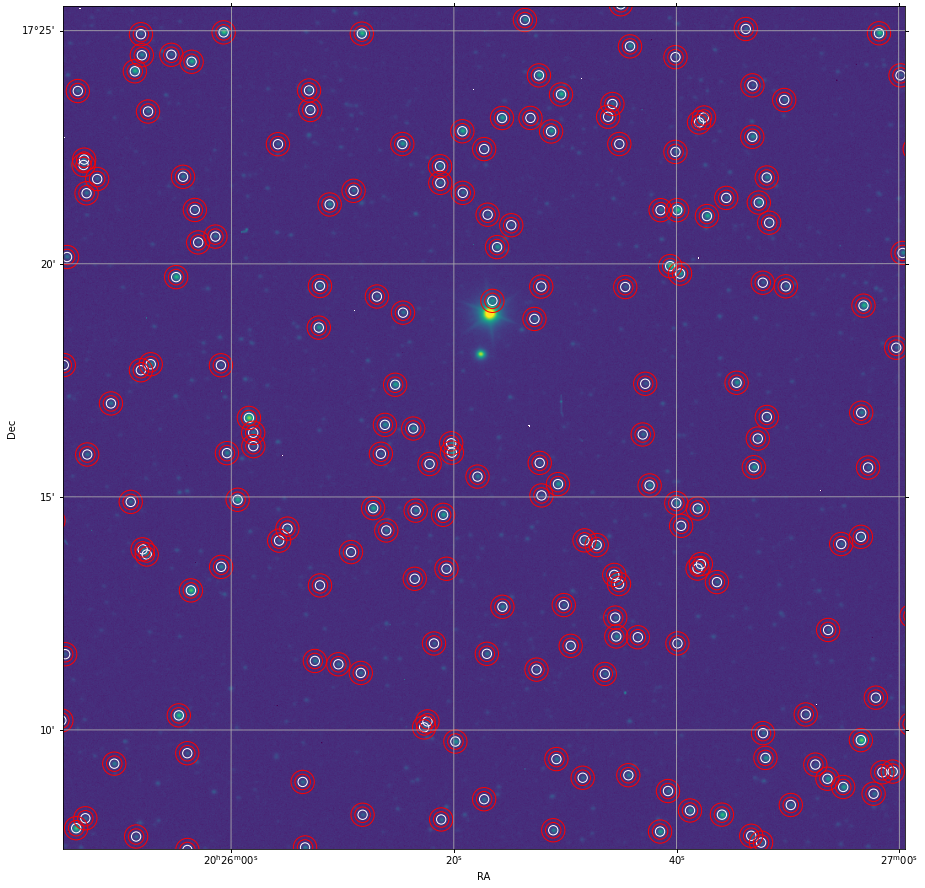

In [194]:
fig = plt.figure(figsize=(12,12))
fig.add_subplot(111, projection=w)
norm = simple_norm(data, 'log', min_percent=0.01, max_percent=100)
plt.imshow(data, origin='lower', cmap=plt.cm.viridis, norm=norm)
pix_aperture.plot(color='white', lw=1)
pix_annulus_aperture.plot(color='red', lw=1)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(1000, 2000)
plt.ylim(1000, 2000)
plt.grid(True)
fig.tight_layout()


# Simple apperture photometry and comparing with the Gaia

In [195]:
annulus_masks = pix_annulus_aperture.to_mask(method='center')

In [227]:
bkg_median = []
for i, mask in enumerate(annulus_masks):

    annulus_data = mask.multiply(data)
    if annulus_data is not None:
        annulus_data_1d = annulus_data[mask.data > 0]
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        bkg_median.append(median_sigclip)
bkg_median = np.array(bkg_median)
phot = aperture_photometry(data, pix_aperture)
phot['annulus_median'] = bkg_median
phot['aper_bkg'] = bkg_median * pix_aperture.area
phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
for col in phot.colnames:
    phot[col].info.format = '%.8g'  # for consistent table output


In [221]:
print(phot)

 id   xcenter   ycenter  aperture_sum annulus_median  aper_bkg aper_sum_bkgsub
        pix       pix                                                         
---- --------- --------- ------------ -------------- --------- ---------------
   1 1839.6783  870.5707    12938.934             69 6637.5603       6301.3739
   2 424.76059 1558.9548    62446.131             72 6926.1499       55519.981
   3 1728.4399 1410.3537    33889.291             71 6829.9533       27059.338
   4 1626.3813 875.75331    20362.636             70 6733.7568       13628.879
   5 2138.3389 1533.2976    40643.818             69 6637.5603       34006.257
   6 556.34541 1511.5863    99537.012          73.25 7046.3955       92490.617
   7 1660.3942 1314.3173    17478.894           72.5 6974.2481       10504.646
   8 1252.4185 612.26851    15498.813             66 6348.9707       9149.8428
   9 1461.9816 1470.2876    44768.324           77.5 7455.2307       37313.094
  10 2063.0348 1409.6793    29640.076             68

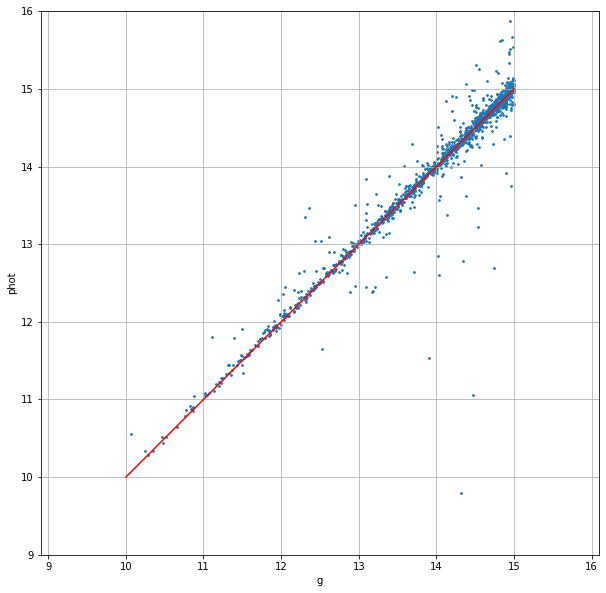

In [225]:
plt.figure(figsize=(10,10))
plt.scatter(res['phot_g_mean_mag'], 24.3-2.5*np.log10(phot['aper_sum_bkgsub']), s=3)
plt.xlabel('g')
plt.ylabel('phot')
plt.axis('equal')
plt.xlim(9,16)
plt.ylim(9,16)
plt.plot([10, 15.0], [10, 15.0], color='r')
plt.grid(True)


# Uncertainties

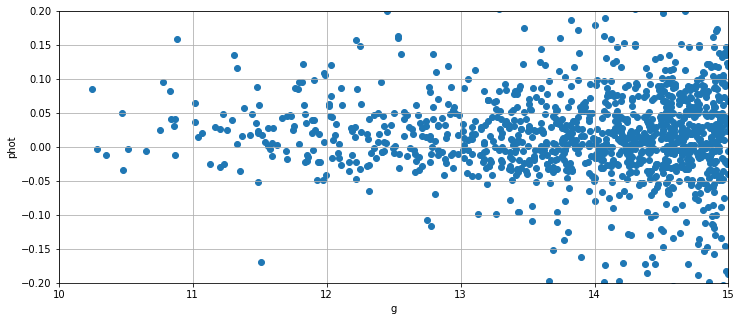

In [240]:
plt.figure(figsize=(12,5))
plt.scatter(res['phot_g_mean_mag'], (24.3-2.5*np.log10(phot['aper_sum_bkgsub']) - res['phot_g_mean_mag']))
plt.xlabel('g')
plt.ylabel('phot')
# plt.axis('equal')
plt.xlim(10,15)
plt.ylim(-0.2,0.2)
# plt.plot([10, 15.0], [10, 15.0], color='r')
plt.grid(True)
plt.show()